In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import pickle as pkl
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf
import keras
import keras_metrics as km

from keras.callbacks import TensorBoard
from keras import regularizers
from custom_callbacks import LrFinder
from custom_callbacks import CycleLearner
from custom_callbacks import reset_weights
from keras.callbacks import ModelCheckpoint
from time import time
from keras.layers import Input, Dense,Dropout,BatchNormalization,LSTM,GRU,Bidirectional,Conv2D, MaxPool2D, Flatten, GlobalAvgPool2D, GlobalMaxPool2D,merge
from keras.models import Model,Sequential
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras import backend as K
import math
import json

# Get the dictionary containing each metric and the loss for each epoch


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13675965087181652870
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10831108506
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8756722384426873946
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [5]:
train_filepath = "train_workspace/"
animalList = ["Human","Pig","Chicken","Rat","Mouse","Dog"]
levelList = ["Strict","Relaxed","Intermediate"]
dataList = ["Ohnologs","No-Ohnologs","Paralogs"]
dataNameList = ["ohnologs","no-ohnologs","paralog"]
sb.set_style("darkgrid")

In [6]:
working_level = "Strict"
kmer_chosen = 8
type_chosen = "cdna"

dataset_complete = pd.read_pickle(train_filepath + working_level + "/datasets/dataset_complete-" + str(kmer_chosen) + "-" + type_chosen + ".pkl")
dataset_diferential = pd.read_pickle(train_filepath + working_level + "/datasets/dataset_diferential-" + str(kmer_chosen) + "-" + type_chosen + ".pkl")

## Start Designing

In [7]:
blast_columns = ["Percent Identical Matches","Aligment Length","Nr Mismatch","Nr Gap Open","Evalue","Bit Score"]

e_values_columns = ["Evalue_Total","Evalue_High","Evalue_Medium","Evalue_Low"]

blast_types = ["High","Medium","Low","Total"]
blast_col_Total = [i + "_Total" for i in blast_columns] 
blast_col_High = [i + "_High" for i in blast_columns]
blast_col_Medium = [i + "_Medium" for i in blast_columns]
blast_col_Low = [i + "_Low" for i in blast_columns]

blast_cols_levels = blast_col_High + blast_col_Medium + blast_col_Low
total_columns = (blast_col_High + blast_col_Medium + blast_col_Low + blast_col_Total + ["Nr Hits"])

non_training_meta_features = ["Sequence-1","Sequence-2","Sequence-1 Id","Sequence-1-Transcript Id","Sequence-2 Id","Sequence-2-Transcript Id","Sequence-1-Transcript-Version","Sequence-2-Transcript-Version"]

sequence_1_metadata = ["Sequence-1 GC","Sequence-1 Length","Sequence-1-Chromosome","Seq-1-Biotype_protein_coding"]
sequence_2_metadata = ["Sequence-2 GC","Sequence-2 Length","Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"]

sequence_1_metadata_diferential = ["Sequence-1 GC","Sequence-1 Length"]
sequence_2_metadata_diferential = ["Sequence-2 GC","Sequence-2 Length"]

sequence_1_metadata_categorical = ["Sequence-1-Chromosome","Seq-1-Biotype_protein_coding"]
sequence_2_metadata_categorical = ["Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"]

species_metadata = ["Specie_Dog","Specie_Human","Specie_Mouse","Specie_Pig","Specie_Rat"]

emb_size = 100
if(type_chosen == "cdna2"):
    emb_size = 200
embedding_1_cols = ["Embedding1_" + str(i) for i in range(0,emb_size)]
embedding_2_cols = ["Embedding2_" + str(i) for i in range(0,emb_size)]

## Models

In [8]:
def get_train_val_test(df):
    df.sample(frac=1,random_state=7)
    df_train, df_test = train_test_split(df, test_size=0.2,random_state=9,stratify=dataset_complete["Is_Ohnolog"])
    df_train, df_val = train_test_split(df_train, test_size=0.2,random_state=3,stratify=df_train["Is_Ohnolog"])
    return (df_train,df_val,df_test)

In [9]:
def save_log(log,name):
    log_dict = log.history    
    json.dump(log_dict, open(train_filepath + working_level + "/model_run_history/" + name + ".json", 'w'))

In [10]:
def get_log(name):
     return json.load(open(train_filepath + working_level + "/model_run_history/" + name + ".json", 'r'))

In [11]:
class EpochLogger(keras.callbacks.Callback):
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.metric_cache = {}        

    def on_epoch_end(self, epoch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log_default = ''            
            metrics_log_main = ''            
            metrics_log_aux = ''            
            for (k, v) in self.metric_cache.items():
                val = v / self.display             
                if("main" in k):
                    if abs(val) > 1e-3:
                        metrics_log_main += ' - %s: %.4f' % (k, val)
                        continue      
                    else:
                        metrics_log_main += ' - %s: %.4e' % (k, val)
                        continue                    
                        
                if("aux" in k): 
                    if abs(val) > 1e-3:
                        metrics_log_aux += ' - %s: %.4f' % (k, val)
                        continue      
                    else:
                        metrics_log_aux += ' - %s: %.4e' % (k, val)
                        continue      
                        
                if abs(val) > 1e-3:
                        metrics_log_default += ' - %s: %.4f' % (k, val)
                else:
                        metrics_log_default += ' - %s: %.4e' % (k, val)                        
                    
            print('step: {}/{} ... {}'.format(self.step,
                                          self.params['epochs'],
                                          metrics_log_default + "\n" + metrics_log_main + "\n" + metrics_log_aux))
            self.metric_cache.clear()

## Change here to use complete or diferential

In [12]:
model_name = ""

chosen_df = dataset_complete

model_name += 'complete' + '-' + str(kmer_chosen) + "-" + type_chosen 

df_train,df_val,df_test = get_train_val_test(chosen_df)
df_train.head()

,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Is_Ohnolog,Sequence-1 GC,Sequence-1 Length,Sequence-1-Chromosome,Percent Identical Matches_High,...,Embedding2_90,Embedding2_91,Embedding2_92,Embedding2_93,Embedding2_94,Embedding2_95,Embedding2_96,Embedding2_97,Embedding2_98,Embedding2_99
12137,1,0,0,0,0,1,0.636336,0.030683,19,0.0,...,10.646241,5.748561,-93.681509,-76.575807,-81.240562,-29.144684,-87.211201,36.582416,28.868005,-87.540005
984,0,1,0,0,0,0,0.514272,0.018526,4,0.0,...,0.760718,30.958423,26.175311,14.720085,-21.730608,151.753806,-7.954189,-49.703928,95.319650,-49.361925
7540,0,0,0,0,1,0,0.566346,0.018975,1,0.0,...,-52.417620,25.988377,-203.205464,54.804432,-168.040204,-16.658954,-222.812571,-1.743560,103.061760,-176.706696
11004,1,0,0,0,0,0,0.491247,0.008055,10,0.0,...,-10.350272,2.944633,-112.708920,-60.783692,-77.906711,-32.114929,-73.236479,24.860617,25.054328,-53.781595
12644,1,0,0,0,0,1,0.601852,0.019725,2,0.0,...,0.501285,-13.793751,-112.080403,-87.522981,-111.304861,-49.672315,-108.855172,31.676184,30.385617,-98.411307


In [13]:
def show_results(model, log,x_test,y_test,bs,cycling=False):
    print(model.evaluate(x_test, y_test, batch_size=bs, verbose=False))
    loss, acc,recall = model.evaluate(x_test, y_test, batch_size=bs, verbose=False)
    print(f'Loss     = {loss:.4f}')
    print(f'Accuracy = {acc:.4f}')
    
    val_loss = log['val_loss']
    val_acc = log['val_acc']
    if cycling:
        val_loss += [loss]
        val_acc += [acc]
        
    fig, axes = plt.subplots(1, 2, figsize=(20,8))
    ax1, ax2 = axes
    ax1.plot(log['loss'], label='train')
    ax1.plot(val_loss, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log['acc'], label='train')
    ax2.plot(val_acc, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

In [14]:
## Flat Model
def flat_model(df_input,name):
    inputs = Input(shape=(len(df_input.columns),))
    # a layer instance is callable on a tensor, and returns a tensor
    
    x = Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.005))(inputs)    
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.005,))(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.005))(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)    
    x = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)
    x = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)
    x = Dense(8, activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x)

    predictions = Dense(1, activation='sigmoid')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model_created = Model(inputs=inputs, outputs=predictions)
    model_created.Name = name
    return model_created
 

In [15]:
def fit_model(train_x,train_y,val_x,val_y,model_train,n_epochs,optimizer,batchsize,model_params = None):
    tensorboard = TensorBoard(log_dir=train_filepath + working_level + "/board_logs/" + model_train.Name + "-" + model_name + "-{}".format(time()))
    checkpoint = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-check-{{epoch:02d}}-{{val_acc:.2f}}.hdf5".format(model_train.Name + "-" + model_name),save_weights_only=True, period = int(n_epochs/5))
    best_model_save = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-best.hdf5".format(model_train.Name + "-" + model_name), monitor='val_acc', save_best_only=True,save_weights_only=True, mode='max')
    logger = EpochLogger(display=25)

    model_train.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy',km.binary_recall()])
    return model_train.fit(train_x.values, train_y.values,verbose = 0,epochs = n_epochs,batch_size=batchsize,validation_data=[val_x.values,val_y.values],callbacks = [tensorboard,checkpoint,best_model_save,logger])  # starts training

In [16]:
df_train_x = df_train.drop(["Is_Ohnolog"],axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)
df_train_y = df_train["Is_Ohnolog"]

df_val_x = df_val.drop(["Is_Ohnolog"],axis=1)
df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
df_val_x = df_val_x.drop(embedding_2_cols,axis=1)
df_val_y = df_val["Is_Ohnolog"]

df_test_x = df_test.drop(["Is_Ohnolog"],axis=1)
df_test_x = df_test_x.drop(embedding_1_cols,axis=1)
df_test_x = df_test_x.drop(embedding_2_cols,axis=1)
df_test_y = df_test["Is_Ohnolog"]

In [17]:
df_train_x.head()

,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Sequence-1 GC,Sequence-1 Length,Sequence-1-Chromosome,Percent Identical Matches_High,Aligment Length_High,...,Nr Gap Open_Total,Evalue_Total,Bit Score_Total,Nr Hits,Seq-1-Biotype_protein_coding,Cosine_Similarity,Sequence-2 GC,Sequence-2 Length,Sequence-2-Chromosome,Seq-2-Biotype_protein_coding
12137,1,0,0,0,0,0.636336,0.030683,19,0.0,0.0,...,0.009881,0.179756,0.006099,0.010784,1,0.942244,0.544745,0.085426,2,1
984,0,1,0,0,0,0.514272,0.018526,4,0.0,0.0,...,0.000000,0.330618,0.005386,0.001961,1,0.959831,0.495958,0.139397,1,1
7540,0,0,0,0,1,0.566346,0.018975,1,0.0,0.0,...,0.007246,0.219875,0.005316,0.001471,1,0.959291,0.501875,0.207057,9,1
11004,1,0,0,0,0,0.491247,0.008055,10,0.0,0.0,...,0.007246,0.307968,0.005766,0.001471,1,0.933802,0.390121,0.069397,11,1
12644,1,0,0,0,0,0.601852,0.019725,2,0.0,0.0,...,0.010870,0.165443,0.005386,0.001961,1,0.905704,0.469108,0.094894,1,1


In [18]:
model = flat_model(df_train_x,"Flat_meta_only")

In [19]:
reset_weights(model)

In [20]:
log = fit_model(df_train_x,df_train_y,df_val_x,df_val_y,model,100,Adamax(),256)

step: 25/100 ...  - loss: 0.6769 - acc: 0.7660 - recall: 0.7590 - val_loss: 0.5992 - val_acc: 0.7689 - val_recall: 0.7381


step: 50/100 ...  - loss: 0.4207 - acc: 0.8214 - recall: 0.8100 - val_loss: 0.4028 - val_acc: 0.8328 - val_recall: 0.8077


step: 75/100 ...  - loss: 0.3973 - acc: 0.8314 - recall: 0.8202 - val_loss: 0.3865 - val_acc: 0.8368 - val_recall: 0.8240


step: 100/100 ...  - loss: 0.3824 - acc: 0.8387 - recall: 0.8312 - val_loss: 0.3689 - val_acc: 0.8466 - val_recall: 0.8406




In [23]:
# FLat Complete with Embeddings
df_train_x = df_train.drop("Is_Ohnolog",axis=1)
df_train_y = df_train["Is_Ohnolog"]

df_val_x = df_val.drop("Is_Ohnolog",axis=1)
df_val_y = df_val["Is_Ohnolog"]

df_test_x = df_test.drop("Is_Ohnolog",axis=1)
df_test_y = df_test["Is_Ohnolog"]

In [24]:
model = flat_model(df_train_x,"Flat_complete")

In [25]:
reset_weights(model)

In [26]:
log = fit_model(df_train_x,df_train_y,df_val_x,df_val_y,model,500,Adamax(),256)

step: 25/500 ...  - loss: 0.9124 - acc: 0.7103 - recall: 0.7220 - val_loss: 0.8042 - val_acc: 0.7045 - val_recall: 0.6893


step: 50/500 ...  - loss: 0.5675 - acc: 0.7363 - recall: 0.7423 - val_loss: 0.5741 - val_acc: 0.7245 - val_recall: 0.6582


step: 75/500 ...  - loss: 0.5437 - acc: 0.7501 - recall: 0.7616 - val_loss: 0.5541 - val_acc: 0.7368 - val_recall: 0.7147


step: 100/500 ...  - loss: 0.5274 - acc: 0.7600 - recall: 0.7778 - val_loss: 0.5477 - val_acc: 0.7403 - val_recall: 0.6936


step: 125/500 ...  - loss: 0.5158 - acc: 0.7665 - recall: 0.7899 - val_loss: 0.5474 - val_acc: 0.7432 - val_recall: 0.6780


step: 150/500 ...  - loss: 0.5055 - acc: 0.7729 - recall: 0.7924 - val_loss: 0.5401 - val_acc: 0.7457 - val_recall: 0.6859


step: 175/500 ...  - loss: 0.4951 - acc: 0.7800 - recall: 0.8020 - val_loss: 0.5432 - val_acc: 0.7490 - val_recall: 0.6945


step: 200/500 ...  - loss: 0.4895 - acc: 0.7840 - recall: 0.8047 - val_loss: 0.5409 - val_acc: 0.7494 - val_recall: 0.6980


ste

In [ ]:
show_results(model,log.history,df_test_x.values,df_test_y.values,256)

## Levels

In [14]:
def show_results_level(model, log,x_test,x_emb_test,y_test,bs,metrics_used):
    metrics_names,metrics = (model.metrics_names,model.evaluate([x_emb_test.values,x_test.values],[y_test.values,y_test.values], batch_size=bs,verbose=False))
    count = 0
    for i in range(0,len(metrics)):
        print(f'{metrics_names[i]}     = {metrics[i]:.4f}')                
    nr_metrics = len(metrics_used)
    fig, axes = plt.subplots(2, nr_metrics, figsize=(18,8))   
    
    i = 0
    for metric in metrics_used:
        match_metrics = [model_metric.split('_')[0] for model_metric in metrics_names if metric in model_metric]
        print(match_metrics)
        if(metric == "loss"):
            match_metrics.remove("loss")
        for match in match_metrics:        
            if(i>=nr_metrics):
                axes[1][i-nr_metrics].plot(log[match + "_" + metric], label="Train")            
                axes[1][i-nr_metrics].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[1][i-nr_metrics].set_xlabel('epoch'); 
                axes[1][i-nr_metrics].set_ylabel(metric + "_" + match)                            
            else:
                axes[0][i].plot(log[match + "_" + metric], label="Train")            
                axes[0][i].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[0][i].set_xlabel('epoch'); 
                axes[0][i].set_ylabel(metric + "_" + match)                            
                
            i += 1            
    for ax in axes:
        for a in ax:
             a.legend()

In [15]:
def show_results_level_RNN(model, log,x_test,x_emb_test,y_test,bs,metrics_used):
    metrics_names,metrics = (model.metrics_names,model.evaluate([x_emb_test.values.reshape(x_emb_test.shape[0],x_emb_test.shape[1],1),x_test.values],[y_test.values,y_test.values], batch_size=bs,verbose=False))
    count = 0
    for i in range(0,len(metrics)):
        print(f'{metrics_names[i]}     = {metrics[i]:.4f}')                
    nr_metrics = len(metrics_used)
    fig, axes = plt.subplots(2, nr_metrics, figsize=(18,8))   
    
    i = 0
    for metric in metrics_used:
        match_metrics = [model_metric.split('_')[0] for model_metric in metrics_names if metric in model_metric]
        print(match_metrics)
        if(metric == "loss"):
            match_metrics.remove("loss")
        for match in match_metrics:        
            if(i>=nr_metrics):
                axes[1][i-nr_metrics].plot(log[match + "_" + metric], label="Train")            
                axes[1][i-nr_metrics].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[1][i-nr_metrics].set_xlabel('epoch'); 
                axes[1][i-nr_metrics].set_ylabel(metric + "_" + match)                            
            else:
                axes[0][i].plot(log[match + "_" + metric], label="Train")            
                axes[0][i].plot(log["val_" + match + "_" + metric], label="Val")       
                axes[0][i].set_xlabel('epoch'); 
                axes[0][i].set_ylabel(metric + "_" + match)                            
                
            i += 1            
    for ax in axes:
        for a in ax:
             a.legend()

In [16]:
def level_model(df_meta_input,df_embeddings,name):    
    input_embedding = Input(shape=(len(df_embeddings.columns),), name='embedding_input')        
    emb_x = Dense(512, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.01))(input_embedding)    
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dropout(0.4)(emb_x)
    emb_x = Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)
    emb_x = Dropout(0.4)(emb_x)
    emb_x = Dense(256, activation='relu',use_bias = False,kernel_regularizer=regularizers.l2(0.01))(emb_x)    
    emb_x = Dropout(0.3)(emb_x)
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)
    emb_x = Dropout(0.3)(emb_x)
    emb_x = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)    
    emb_x = Dropout(0.3)(emb_x)
    emb_x = Dense(32, activation='relu',use_bias = False)(emb_x)
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_x)        
    emb_x_out = Dense(1, activation='sigmoid',name="aux")(emb_x)
    
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x, meta_input])
    x = Dense(128, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(1, activation='sigmoid',name="main")(x)

    # This creates a model that includes
    # the Input layer and three Dense layers                       
    model_created = Model(inputs=[input_embedding, meta_input], outputs=[emb_x_out,predictions])
    model_created.Name = name
    return model_created

In [17]:
def fit_model_level(train_x,train_emb_x,train_y,val_x,val_emb_x,val_y,model_train,n_epochs,optimizer,batchsize,loss_weigths,verb):
    tensorboard = TensorBoard(log_dir=train_filepath + working_level + "/board_logs/" + model_train.name + "-" + model_name + "-{}".format(time()))
    checkpoint = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-check-{{epoch:02d}}-{{val_main_acc:.2f}}.hdf5".format(model_train.Name + "-" + model_name),save_weights_only=True, period = int(n_epochs/5))
    best_model_save = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-best.hdf5".format(model_train.Name + "-" +  model_name), monitor='val_main_acc',save_weights_only=True,  save_best_only=True, mode='max')
    logger = EpochLogger(display=25)

    model_train.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy',km.binary_recall()],loss_weights=loss_weigths)
    size = len(train_emb_x)
    return model_train.fit([train_emb_x,train_x], y= [train_y,train_y],verbose = verb,validation_data=([val_emb_x,val_x],[val_y,val_y]),epochs = n_epochs,batch_size=batchsize,callbacks = [tensorboard,checkpoint,best_model_save,logger])  # starts training

In [20]:
df_train_x = df_train.drop("Is_Ohnolog",axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)

df_train_emb_x = pd.concat([df_train[embedding_1_cols],df_train[embedding_2_cols]],axis=1,sort=False)
df_train_y = df_train["Is_Ohnolog"]

df_val_x = df_val.drop("Is_Ohnolog",axis=1)
df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
df_val_x = df_val_x.drop(embedding_2_cols,axis=1)

df_val_emb_x = pd.concat([df_val[embedding_1_cols],df_val[embedding_2_cols]],axis=1,sort=False)
df_val_y = df_val["Is_Ohnolog"]

df_test_x = df_test.drop("Is_Ohnolog",axis=1)
df_test_x = df_test_x.drop(embedding_1_cols,axis=1)
df_test_x = df_test_x.drop(embedding_2_cols,axis=1)

df_test_emb_x =  pd.concat([df_test[embedding_1_cols],df_test[embedding_2_cols]],axis=1,sort=False)
df_test_y = df_test["Is_Ohnolog"]

In [35]:
df_train_x.head()

,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Sequence-1 GC,Sequence-1 Length,Sequence-1-Chromosome,Percent Identical Matches_High,Aligment Length_High,...,Nr Gap Open_Total,Evalue_Total,Bit Score_Total,Nr Hits,Seq-1-Biotype_protein_coding,Cosine_Similarity,Sequence-2 GC,Sequence-2 Length,Sequence-2-Chromosome,Seq-2-Biotype_protein_coding
12137,1,0,0,0,0,0.636336,0.030683,19,0.0,0.0,...,0.009881,0.179756,0.006099,0.010784,1,0.942244,0.544745,0.085426,2,1
984,0,1,0,0,0,0.514272,0.018526,4,0.0,0.0,...,0.000000,0.330618,0.005386,0.001961,1,0.959831,0.495958,0.139397,1,1
7540,0,0,0,0,1,0.566346,0.018975,1,0.0,0.0,...,0.007246,0.219875,0.005316,0.001471,1,0.959291,0.501875,0.207057,9,1
11004,1,0,0,0,0,0.491247,0.008055,10,0.0,0.0,...,0.007246,0.307968,0.005766,0.001471,1,0.933802,0.390121,0.069397,11,1
12644,1,0,0,0,0,0.601852,0.019725,2,0.0,0.0,...,0.010870,0.165443,0.005386,0.001961,1,0.905704,0.469108,0.094894,1,1


In [36]:
model = level_model(df_train_x,df_train_emb_x,"Level_model")

In [37]:
reset_weights(model)

In [38]:
log = fit_model_level(df_train_x,df_train_emb_x,df_train_y,df_val_x,df_val_emb_x,df_val_y,model,1000,Adamax(),256,[0.2,1],0)

step: 25/1000 ...  - loss: 2.8518 - val_loss: 2.5492
 - main_loss: 0.5312 - main_acc: 0.7266 - main_recall: 0.6850 - val_main_loss: 0.4973 - val_main_acc: 0.7555 - val_main_recall: 0.7576
 - aux_loss: 0.6302 - aux_acc: 0.6421 - aux_recall: 0.6841 - val_aux_loss: 0.6352 - val_aux_acc: 0.6510 - val_aux_recall: 0.7552
step: 50/1000 ...  - loss: 0.5877 - val_loss: 0.5572
 - main_loss: 0.3589 - main_acc: 0.8426 - main_recall: 0.7492 - val_main_loss: 0.3304 - val_main_acc: 0.8543 - val_main_recall: 0.7761
 - aux_loss: 0.6057 - aux_acc: 0.6687 - aux_recall: 0.7480 - val_aux_loss: 0.6058 - val_aux_acc: 0.6695 - val_aux_recall: 0.7725
step: 75/1000 ...  - loss: 0.4991 - val_loss: 0.4740
 - main_loss: 0.3146 - main_acc: 0.8617 - main_recall: 0.7753 - val_main_loss: 0.2899 - val_main_acc: 0.8684 - val_main_recall: 0.7914
 - aux_loss: 0.6075 - aux_acc: 0.6684 - aux_recall: 0.7741 - val_aux_loss: 0.6066 - val_aux_acc: 0.6687 - val_aux_recall: 0.7874
step: 100/1000 ...  - loss: 0.4685 - val_loss: 0.

loss     = 0.3625
aux_loss     = 0.5701
main_loss     = 0.2240
aux_acc     = 0.7098
aux_recall     = 0.8282
main_acc     = 0.9095
main_recall     = 0.8320
['loss', 'aux', 'main']
['aux', 'main']
['aux', 'main']


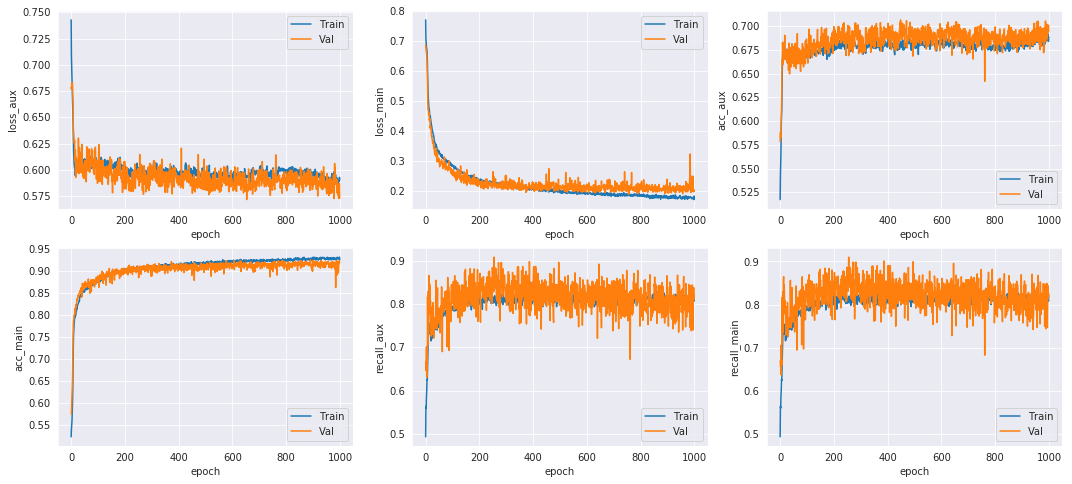

In [39]:
show_results_level(model,log.history,df_test_x,df_test_emb_x,df_test_y,256,["loss","acc","recall"])

In [ ]:
def level_model_rnn(df_meta_input,df_embeddings,name,rnn_size,bs):
    input_embedding = Input(shape=(len(df_embeddings.columns),1), name='embedding_input')
        
    emb_x = GRU(rnn_size, activation='relu',kernel_regularizer=regularizers.l2(0.01))(input_embedding)    
    emb_x_out = Dense(1, activation='sigmoid',name="aux")(emb_x)
    
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x, meta_input])
    x = Dense(128, activation='relu')(x)    
    x = Dense(128, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)    
    x = Dense(32, activation='relu')(x)    
    x = Dense(16, activation='relu')(x)    
    x = Dense(8, activation='relu')(x)

    predictions = Dense(1, activation='sigmoid',name="main")(x)

    # This creates a model that includes
    # the Input layer and three Dense layers                       
    model_created = Model(inputs=[input_embedding, meta_input], outputs=[emb_x_out,predictions])
    model_created.Name = name
    return model_created

In [ ]:
model = level_model_rnn(df_train_x,df_train_emb_x,"Level_model_RNN",128,128)

In [ ]:
model.summary()

In [ ]:
df_train_x.head()

In [ ]:
log = fit_model_level(df_train_x,df_train_emb_x.values.reshape(df_train_emb_x.shape[0],df_train_emb_x.shape[1],1),df_train_y,df_val_x,df_val_emb_x.values.reshape(df_val_emb_x.shape[0],df_val_emb_x.shape[1],1),df_val_y,model,1500,Adagrad(),128,[0.2,1])

In [ ]:
show_results_level_RNN(model,log.history,df_test_x,df_test_emb_x,df_test_y,256,["loss","acc","recall"])

In [27]:
def level_model_conv(df_meta_input,df_embeddings,name,bs):    
    input_embedding = Input(shape=(len(df_embeddings.columns),len(df_embeddings.columns),1), name='embedding_input')        
    emb_x = Conv2D(64,5, activation='relu')(input_embedding)    
    emb_x = MaxPool2D()(emb_x)
    emb_x = Conv2D(32,4, activation='relu')(emb_x)    
    emb_x = Conv2D(16,3, activation='relu')(emb_x)                
    emb_x = Flatten()(emb_x)
    emb_x_out = Dense(1, activation='sigmoid',name="aux")(emb_x)
        
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x, meta_input])    
    x = Dense(128, activation='relu')(x)    
    x = Dense(64, activation='relu')(x)        
    x = Dense(32, activation='relu')(x)    
    x = Dense(16, activation='relu')(x)    
    x = Dense(8, activation='relu')(x)

    predictions = Dense(1, activation='sigmoid',name="main")(x)

    # This creates a model that includes
    # the Input layer and three Dense layers                       
    model_created = Model(inputs=[input_embedding, meta_input], outputs=[emb_x_out,predictions])
    model_created.Name = name
    return model_created

In [ ]:
model = level_model_conv(df_train_x,df_train_emb_x[embedding_1_cols],"Level_model_Conv",256)

In [ ]:
model.summary()

In [ ]:
log = fit_model_level(df_train_x.values,matrix_train,df_train_y.values,df_val_x.values,matrix_test,df_val_y.values,model,500,Adamax(),128,[0.2,1])

## Siames

In [ ]:
df_train,df_val,df_test = get_train_val_test(dataset_diferential)

In [ ]:
import keras.backend as K
from keras.layers import Lambda

def get_tensor_embedding_layer(input_embedding):
    emb_x = Dense(256, activation='relu')(input_embedding)            
    emb_x = Dense(256, activation='relu')(emb_x)        
    emb_x = Dense(128, activation='relu')(emb_x)        
    emb_x = Dense(64, activation='relu')(emb_x)        
    emb_x = Dense(32, activation='relu')(emb_x)          
    emb_x_out = Dense(1, activation='sigmoid')(emb_x)
    
    return emb_x,emb_x_out

def level_siames(df_meta_input,df_embeddings_1,df_embeddings_2,name,bs):    
    
    input_embedding_1 = Input(shape=(len(df_embeddings_1.columns),), name='embedding_input_1')        
    input_embedding_2 = Input(shape=(len(df_embeddings_2.columns),), name='embedding_input_2')        
    
    emb_x_1,emb_x_out_1 = get_tensor_embedding_layer(input_embedding_1)    
    emb_x_2,emb_x_out_2 = get_tensor_embedding_layer(input_embedding_2)    
        
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    x = keras.layers.concatenate([emb_x_out_1,meta_input,emb_x_out_2])
    x = Dense(128, activation='relu')(x)        
    x = Dense(128, activation='relu')(x)            
    x = Dense(64, activation='relu')(x)        
    x = Dense(32, activation='relu')(x)       
    x = Dense(32, activation='relu')(x)       
    x = Dense(16, activation='relu')(x)        
    x = Dense(8, activation='relu')(x)    
    predictions = Dense(1, activation='sigmoid',name="main")(x)
        
    model_created = Model(inputs=[input_embedding_1,input_embedding_2,meta_input], outputs=[predictions])
    model_created.Name = name
    return model_created


In [ ]:
import keras.backend as K
from keras.layers import Lambda

def get_tensor_embedding_layer(input_embedding):
    emb_x = Dense(256, activation='relu')(input_embedding)            
    emb_x = Dense(256, activation='relu')(emb_x)        
    emb_x = Dense(128, activation='relu')(emb_x)        
    emb_x = Dense(64, activation='relu',)(emb_x)        
    emb_x = Dense(32, activation='relu',)(emb_x)          
    emb_x_out = Dense(1, activation='sigmoid')(emb_x)
    
    return emb_x,emb_x_out

def level_siames_merge_layer(df_meta_input,df_embeddings_1,df_embeddings_2,name,bs):    
    
    input_embedding_1 = Input(shape=(len(df_embeddings_1.columns),), name='embedding_input_1')        
    input_embedding_2 = Input(shape=(len(df_embeddings_2.columns),), name='embedding_input_2')        
    
    emb_x_1,emb_x_out_1 = get_tensor_embedding_layer(input_embedding_1)    
    emb_x_2,emb_x_out_2 = get_tensor_embedding_layer(input_embedding_2)    
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([emb_x_out_1, emb_x_out_2])
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')
    
    x = keras.layers.concatenate([L1_distance,meta_input])
    x = Dense(128, activation='relu')(x)        
    x = Dense(128, activation='relu')(x)            
    x = Dense(64, activation='relu')(x)    
    x = Dense(32, activation='relu')(x)       
    x = Dense(32, activation='relu')(x)       
    x = Dense(16, activation='relu')(x)        
    x = Dense(8, activation='relu')(x)    
    predictions = Dense(1, activation='sigmoid',name="main")(x)
        
    model_created = Model(inputs=[input_embedding_1,input_embedding_2,meta_input], outputs=[predictions])
    model_created.Name = name
    return model_created



In [ ]:
def fit_model_siames(train_x,train_emb_x_1,train_emb_x_2,train_y,val_x,val_emb_x_1,val_emb_x_2,val_y,model_train,n_epochs,optimizer,batchsize,loss_weigths,verb):
    tensorboard = TensorBoard(log_dir=train_filepath + working_level + "/board_logs/" + model_train.name + "-" + model_name + "-{}".format(time()))
    checkpoint = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-check-{{epoch:02d}}-{{val_acc:.2f}}.hdf5".format(model_train.name + "-" + model_name),save_weights_only=True,  period = int(n_epochs/5))
    best_model_save = ModelCheckpoint(train_filepath + working_level + "/model_checkpoints/{0}-best.hdf5".format(model_train.name + "-" + model_name), monitor='val_acc', save_weights_only=True, save_best_only=True, mode='max')
    logger = EpochLogger(display=25)

    model_train.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy',km.binary_recall()],loss_weights=loss_weigths)    
    return model_train.fit([train_emb_x_1,train_emb_x_2,train_x], y= [train_y],verbose = verb,validation_data=([val_emb_x_1,val_emb_x_2,val_x],[val_y]),epochs = n_epochs,batch_size=batchsize,callbacks = [tensorboard,checkpoint,best_model_save,logger])  # starts training

In [25]:
df_train_x = df_train.drop("Is_Ohnolog",axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)

df_train_emb_x_1 = df_train[embedding_1_cols]
df_train_emb_x_2 = df_train[embedding_2_cols]
df_train_y = df_train["Is_Ohnolog"]

df_val_x = df_val.drop("Is_Ohnolog",axis=1)
df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
df_val_x = df_val_x.drop(embedding_2_cols,axis=1)

df_val_emb_x_1 = df_val[embedding_1_cols]
df_val_emb_x_2 = df_val[embedding_2_cols]                  
df_val_y = df_val["Is_Ohnolog"]

df_test_x = df_test.drop("Is_Ohnolog",axis=1)
df_test_x = df_test_x.drop(embedding_1_cols,axis=1)
df_test_x = df_test_x.drop(embedding_2_cols,axis=1)

df_test_emb_x_1 =  df_test[embedding_1_cols]
df_test_emb_x_2 =  df_test[embedding_2_cols]
df_test_y = df_test["Is_Ohnolog"]

In [ ]:
model = level_siames_merge_layer(df_train_x,df_train_emb_x_1,df_train_emb_x_2,"Level_Siames",128)

In [ ]:
log = fit_model_siames(df_train_x.values,df_train_emb_x_1.values,df_train_emb_x_2.values,df_train_y.values,df_val_x.values,df_val_emb_x_1.values,df_val_emb_x_2.values,df_val_y.values,model,500,Adamax(),128,[1],0)

## Show Models

In [21]:
board_dir = train_filepath + working_level + "/model_checkpoints/"

In [23]:
new_model =  level_model(df_train_x,df_train_emb_x,"Level")
new_model.load_weights(board_dir + new_model.Name + "-complete-8-cdna-best.hdf5")
new_model.compile(optimizer=Adamax(),loss='binary_crossentropy',metrics=['accuracy',km.binary_recall()])
new_log = get_log(new_model.Name + "-complete-8-cdna")

loss     = 0.7939
aux_loss     = 0.5645
main_loss     = 0.2064
aux_acc     = 0.7137
aux_recall     = 0.8137
main_acc     = 0.9174
main_recall     = 0.8174
['loss', 'aux', 'main']
['aux', 'main']
['aux', 'main']


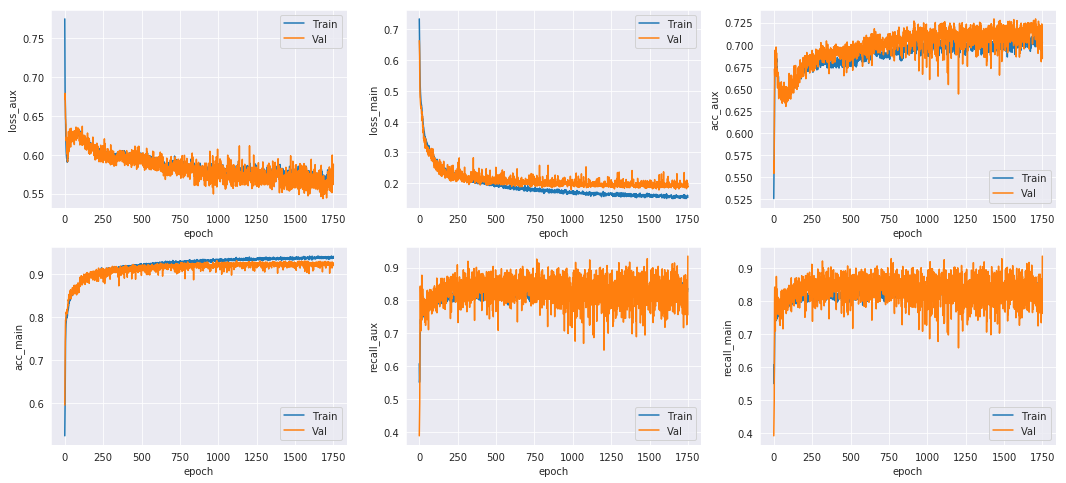

In [24]:
show_results_level(new_model,new_log,df_test_x,df_test_emb_x,df_test_y,256,["loss","acc","recall"])